### Define own method that implements Diffusion Maps (DMs)

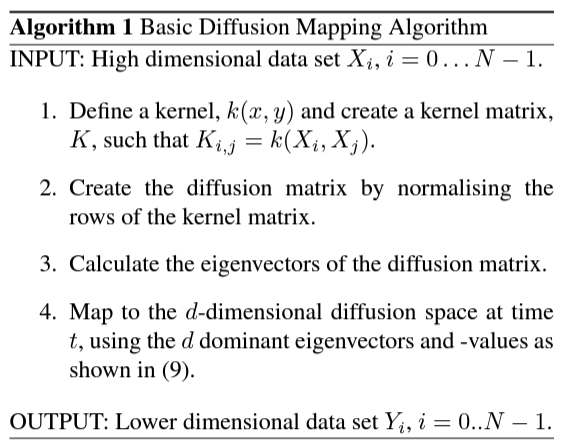

[Picture taken from PorteHerbstHeremanVanDerWalt2008]

In [1]:
# Imports
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt
from matplotlib import offsetbox

from sklearn.preprocessing import MinMaxScaler

In [2]:
def get_diffusion_map(X, dim, kernel='exp', epsilon=1, d=1, plot_eigenvalues=True, plot_eigenvalues_display_range=range(10), t=1):
    """ Dimensionality reduction with Diffusion Maps

    Keyword arguments:
    X -- Data matrix with M rows (observations) and N columns (features)
    dim -- Reduced number of dimensions
    kernel -- Type of kernel. 'exp' for exponential kernel, 'polynom' for polynomial kernel, 'matrix_exp' for exponential kernel
              for matrices (default 'exp')
    epsilon -- Epsilon for exponential kernel (default 1)
    d -- d for polynomial kernel (default 1)
    plot_eigenvalues -- Indicates whether eigenvalues are plotted (default True)
    plot_eigenvalues_display_range -- Indicates range of plotted eigenvalues if plot_eigenvalues is True (default range(10))
    t -- Time parameter (default 1)
    """
    
    # M observations, N features    
    M = X.shape[0]
    N = X.shape[1]
    
    # 1. Define kernel and kernel matrix
    if kernel == 'exp':              
        print(f"Run diffusion maps algorithm with an exponential kernel (eps={epsilon}) and t={t}") 
        K = euclidean_exponential_kernel(X, epsilon=epsilon)

    elif kernel == 'polynom':
        print(f"Run diffusion maps algorithm with a polynomial kernel (d={d}) and t={t}") 
        K = polynomial_kernel(X, d=d)
        
    elif kernel == 'matrix_exp':
        print(f"Run diffusion maps algorithm with an exponential kernel for matrices (eps={epsilon}) and t={t}") 
        K = frobenius_exponential_kernel_for_matrices(X, epsilon=epsilon)
    else:
        print("kernel not given")
        return None
    # K.shape

    # 2. Create diffusion matrix
    D = np.diag(np.sum(K, axis=1))
    P = np.linalg.inv(D) @ K  
    # np.sum(P, axis=1)

    # 3. Calculate eigenvectors and eigenvalues
    eigenvalues, eigenvectors = eigh(P)
    #eigenvalues, eigenvectors = np.linalg.eig(P)
    
    # Sort eigenvalues and corresponding left eigenvectors in descending order
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:,idx]

    # Plot eigenvalues (without first eigenvalue)
    if plot_eigenvalues:
        plt.figure(figsize=(10, 6))
        plt.plot(plot_eigenvalues_display_range, eigenvalues[1:][plot_eigenvalues_display_range], marker='o', linestyle='-', color='b')
        plt.title('Decay of Eigenvalues (first eigenvalue removed)')
        plt.xlabel('Eigenvalue Index')
        plt.ylabel('Eigenvalue')
        plt.grid(True)
        plt.show()

    # 4. Map to d-dimensional diffusion space at time t
    # Y_prime is defined according to PorteHerbstHeremanVanDerWalt2008: Y_prime = [Y_prime_1 ... Y_prime_M]
    Y_prime_reduced = (eigenvalues[:dim] ** t) * eigenvectors[:,:dim] 
    
    return eigenvalues, eigenvectors, Y_prime_reduced.T

In [8]:
def euclidean_exponential_kernel(data_matrix, epsilon=1):
    """ Defines euclidean exponential kernel

    Keyword arguments:
    data_matrix -- Input data matrix
    epsilon -- epsilon parameter for exponential kernel (default 1)
    """
    
    m = data_matrix.shape[0]
    n = data_matrix.shape[1]
    result = np.zeros((m,m))
    
    for i in range(m):
        for j in range(m):
            a = data_matrix[i,:]
            b = data_matrix[j,:]
            dist = np.linalg.norm(a-b)
            #result[i,j] = np.exp(-(dist)**2/epsilon)
            result[i,j] = np.exp(-((dist)**2)/(2 * epsilon**2))
            
    return result

In [9]:
def polynomial_kernel(data_matrix, d=1):
    """ Defines polynomial kernel

    Keyword arguments:
    data_matrix -- Input data matrix
    d -- d parameter for polynomial kernel (default 1)
    """
    
    m = data_matrix.shape[0]
    n = data_matrix.shape[1]
    result = np.zeros((m,m))
    
    for i in range(m):
        for j in range(m):
            
            result[i,j] = (np.dot(data_matrix[i,:].T, data_matrix[j,:]) + 1) ** d
            
    return result

In [10]:
def frobenius_exponential_kernel_for_matrices(data_matrices, epsilon=1):
    """ Defines Frobenius exponential kernel for matrices

    Keyword arguments:
    data_matrix -- Input data matrix
    epsilon -- epsilon parameter for exponential kernel (default 1)
    """
    
    data_matrices_shape = data_matrices.shape
    
    # Check if input is suitable, i.e. data_matrix is array of square matrices
    if len(data_matrices_shape) == 3 and data_matrices_shape[1] == data_matrices_shape[2]:

        number_matrices = data_matrices_shape[0]
        result = np.zeros((number_matrices,number_matrices))
        
        for i in range(number_matrices):
            for j in range(number_matrices):
                A = data_matrices[i,:,:]
                B = data_matrices[j,:,:]

                # Implement Frobenius distance based on Frobenius norm
                dist = ((A-B) ** 2).sum()
                result[i,j] = np.exp(-((dist)**2)/(2 * epsilon**2))
                
        return result

    else:
        print("Input has the wrong format. Input needs to be of the shape [number_matrices, m, n]")
        return None

In [6]:
n_eps = 4


[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

In [7]:
def find_opt_eps_for_dm(X, n_eps=4):
    """Find optimal epsilon for Gaussian kernel by a method developed in
    SingerEtAl2009 (Detecting the slow manifold by anisotropic diffusion maps)

    Keyword arguments:
    X -- Data matrix with M rows (observations) and N columns (features)
    n_eps -- Number of epsilons (negative powers and positive powers of 10) to plot in x-axis 
            (default 4, results in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000])
    """

    # Calculate epsilons
    epss = [10**a for a in range(-n_eps,n_eps)]
    
    # Number of epsilons 
    n_epss = len(epss)

    # M observations, N features    
    M = X.shape[0]
    N = X.shape[1]
    
    # List of Ls
    Ls = np.zeros(n_epss)

    # Loop epsilons
    for cnt, eps in enumerate(epss):

        # Placeholder for result
        result = np.zeros((M,M))

        # Loop data matrixand calculate kernel
        for i in range(M):
            for j in range(M):
                a = X[i,:]
                b = X[j,:]
                dist = np.linalg.norm(a-b)
                result[i,j] = np.exp(-(dist)**2/eps)

        # Save resulting L
        Ls[cnt] = result.sum()

        # Print progress
        print(f"{100*cnt/n_epss}%")

    # Display resulting log-log-plot
    plt.loglog(epss, Ls, linestyle='--', marker='o')

In [ ]:
def plot_embedding(X, title):
    """ Plot digits embedding.

    Keyword arguments:
    X -- Data matrix with M rows (observations) and N columns (features)
    title -- Title of plot
    """
    # Plot
    _, ax = plt.subplots()
    X = MinMaxScaler().fit_transform(X)

    for digit in digits.target_names:
        ax.scatter(
            *X[y == digit].T,
            marker=f"${digit}$",
            s=60,
            color=plt.cm.Dark2(digit),
            alpha=0.425,
            zorder=2,
        )
    shown_images = np.array([[1.0, 1.0]])  # just something big
    for i in range(X.shape[0]):
        # plot every digit on the embedding
        # show an annotation box for a group of digits
        dist = np.sum((X[i] - shown_images) ** 2, 1)
        if np.min(dist) < 4e-3:
            # don't show points that are too close
            continue
        shown_images = np.concatenate([shown_images, [X[i]]], axis=0)
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r), X[i]
        )
        imagebox.set(zorder=1)
        ax.add_artist(imagebox)

    ax.set_title(title)
    ax.axis("off")    